<a href="https://colab.research.google.com/github/sureshrongalirs/Generate-Faces-Using-GAN-s-Generator-and-Discriminator-/blob/main/Generate_Faces_Using_GAN's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We have folder of images of the celebrity, Now using these images we are going to create one GAN architecture and try to generate some fake images.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [ ]:
!unzip -q "/content/drive/MyDrive/Projects/Generate Faces Using GANs/archive.zip" -d "/content/drive/MyDrive/Projects/Generate Faces Using GANs"

We need to get all the images from the directory and we need to preprocessing the images. For this we are using keras and need to pass color_mode for RGB for making all images as color mode, batch size for it return number of images to return in batch for each step in training so that it can helps to speedup training by using vectorized operations and reduce memory usage compared to loading all the images at once, image_size for make all the images size is (32x32) it makes resize all the images to the constant dimenstions, shuffle the data so that model does not learn from the order of the data  which could cause inherent order leads to overfitting, seed for random for shuffling.

In [ ]:
directory = "/content/drive/MyDrive/Projects/Generate Faces Using GANs/img_align_celeba"



In [ ]:
#Get all images from dir
dataset = tf.keras.preprocessing.image_dataset_from_directory(directory = directory,
                                                              color_mode = "rgb",
                                                              batch_size = 128,
                                                              image_size = (32,32),
                                                              shuffle = True,
                                                              seed = 42)

Found 202599 files belonging to 1 classes.


Now we need to normalize the data using minimum value is zero, maximum value is 255. So divide each image with 255 for normalize the data. Using map function so that it applies each element or batch of the dataset. x/255 operation is scales the pixel values of the image to the range [0,1] as it helps the model train more efficiently and prevents issues related to large input values.

In [ ]:
dataset = dataset.map(lambda x, y: x / 255.00)

Add Image grid for create grid of sub plots for displaying multiple images in customizable layout

In [ ]:
#Grid of Image
from mpl_toolkits.axes_grid1 import ImageGrid

Here we are using iterator it allows to traverse through the dataset one batch at a time, instead of loading entire dataset into memory.
After that every batch of images from the iterator converts the data into numpy array for easily access the pixel data.

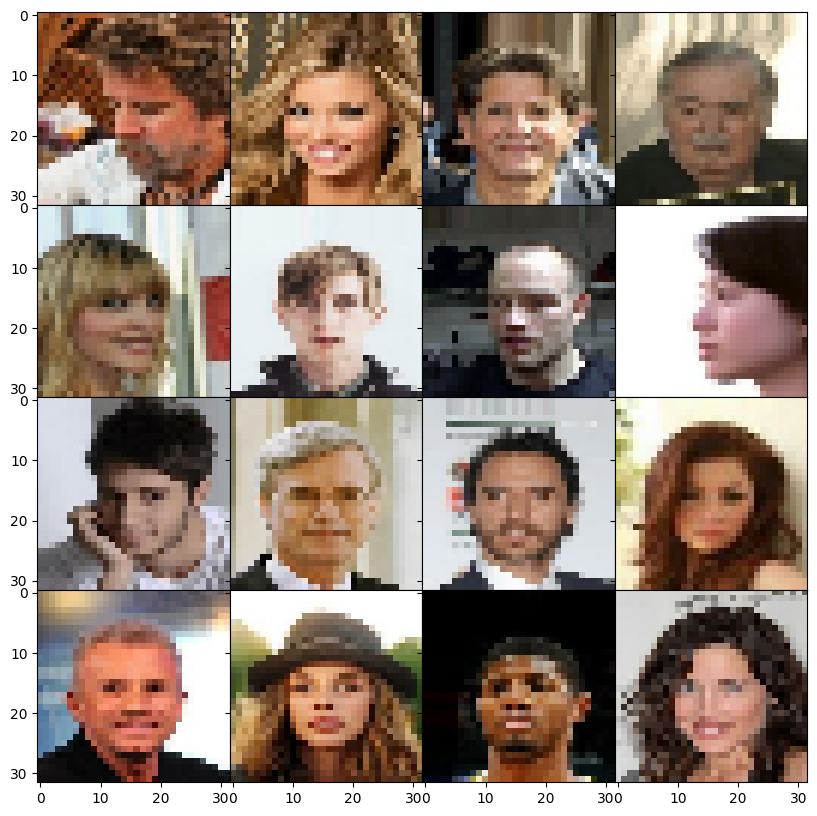

In [ ]:
it = iter(dataset)
one_batch = next(it).numpy()
images = one_batch[:16,:,:,:]

#show the image
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4,4),
         axes_pad=0)
for ax,im in zip(grid, images):
    ax.imshow(im)
plt.show()


GAN's Architecture: It is called as Generative adversial network, it actually generates some fake images, we can also do the image to image translation also we can do the data augmentation. so finally it creats some random data.
Generator is used to generate fake images. It used to fake images using latent vector and noises.
Discriminator is try to classify the images like which one is fake and which one is real.
Discriminator can be image classification.
In general we have passes some random noises inside the generator then generator using deconvolution neural networks and create some faces. Now real faces passes inside the descriminator where as discriminator is deep convolutional neural networks. now discriminator classifies which one is real and which one is fake.


Discriminator model using Keras, a high-level neural network API in TensorFlow. The discriminator is a crucial part of a Generative Adversarial Network (GAN). It classifies whether an input image is "real" (from the training dataset) or "fake" (generated by the generator).
2D convolution layer used to extract features from the input images.
Leaky ReLU activation function that helps avoid the dying ReLU problem
Dropout Regularization technique that randomly sets a fraction of input units to zero during training to prevent overfitting.
Flatten Converts the 3D feature maps into a 1D vector.
Dense Fully connected layer used to make predictions, reducing the feature to scaler value
Applies an activation function (like sigmoid, softmax, etc.) to the output of the layer. The output is passed through a sigmoid activation, squashing the output to a value between 0 and 1, which is suitable for binary classification (real vs. fake image)
The input layer accepts images of size 32x32 pixels with 3 color channels (RGB). The shape of the input tensor is (32, 32, 3).
The convolution layers progressively reduce the spatial dimensions of the feature maps (e.g., from 32x32 to 16x16, 8x8, 4x4, etc.), while increasing the depth (number of filters).




In [ ]:
from tensorflow.keras.layers import Conv2D, LeakyReLU,BatchNormalization, Dropout, Flatten, Dense, Activation, Reshape
from tensorflow.keras import Model, Input

def discriminator_model():
    disc_input = Input(shape=(32,32,3), name='discriminator_network')
    x=Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same')(disc_input)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)

    x=Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)

    x=Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)

    x=Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)

    x=Flatten()(x)
    x=Dense(1)(x)

    output = Activation('sigmoid')(x)

    disc=Model(inputs = disc_input, outputs=output)

    return disc

In [ ]:
disc_model = discriminator_model()
disc_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ discriminator_network           │ (None, 32, 32, 3)      │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,281 (1.13 MB)

 Trainable params: 297,281 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Conv2DTranspose: This is the key layer for the generator, often called "deconvolution" or "upsampling." It is used to upsample the feature maps (reverse of Conv2D).
default, the latent vector z_dim has a size of 100.
The generator takes as input a latent vector of shape (z_dim,). This vector is typically sampled from a random distribution (e.g., normal or uniform distribution).
z_dim=100 means the input vector has 100 dimensions, which will eventually be transformed into an image.
This dense layer takes the gen_input (the latent vector of size z_dim) and transforms it into a 1D vector of size 8*8*3 = 192. This represents a 3-channel (RGB) image of size 8x8 pixels.
BatchNormalization: Normalizes the activations from the previous layer. It ensures that the output has zero mean and unit variance, which helps stabilize and speed up training.
LeakyReLU: Applies the Leaky ReLU activation function, allowing small negative values instead of setting negative values to zero (as in the standard ReLU). This helps with the "dying ReLU" issue.
The latent vector (random noise) of size 100 is transformed through a series of dense and transposed convolution layers, which gradually upsample it into a 32x32 RGB image.
Batch normalization and LeakyReLU are applied throughout to stabilize training and add non-linearity.
The final output is a 32x32 RGB image, which the generator tries to make look as realistic as possible to fool the discriminator in a GAN setup.

In [ ]:
from tensorflow.keras.layers import Conv2D, LeakyReLU,BatchNormalization, Dropout, Flatten, Dense, Activation, Reshape, Conv2DTranspose
from tensorflow.keras import Model, Input
def generator_model(z_dim=100):
    gen_input = Input(shape=(z_dim,), name='generator_network')

    x = Dense(8*8*3)(gen_input)
    x = Reshape(target_shape=(8,8,3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=512, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=256, kernel_size=3, strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=128, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)


    x = Conv2DTranspose(filters=64, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(filters=3, kernel_size=3, strides=(1,1), padding='same')(x)
    fake_images_gen = LeakyReLU()(x)

    model_gen=Model(inputs = gen_input, outputs=fake_images_gen)

    return model_gen

In [ ]:
gen_model = generator_model()
gen_model.summary(0)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator_network (InputLayer)  │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 192)            │        19,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 3)        │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 8, 8, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 8, 8, 512)      │        14,336 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 16, 16, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,736,143 (6.62 MB)

 Trainable params: 1,733,961 (6.61 MB)

 Non-trainable params: 2,182 (8.52 KB)

The Adam optimizer is an adaptive gradient descent optimizer. It combines the advantages of both AdaGrad and RMSProp algorithms and is widely used for training deep learning models due to its efficiency and good performance in practice.
It adjusts the learning rate during training and helps in faster convergence.
The binary cross-entropy loss is used for binary classification problems, which is exactly what the discriminator is doing: classifying whether an image is real (label = 1) or fake (label = 0).
disc_model.compile() configures the discriminator model for training: Adam optimizer is used to optimize the model. Binary cross-entropy loss is used because it's a binary classification task (real vs fake). Accuracy is tracked as a metric to monitor the discriminator's performance.

In [ ]:
disc_model = discriminator_model()
gen_model = generator_model()
# Image Classification CNN
# Compile the model that trains disc.
disc_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

By setting trainable = False for the discriminator, we prevent the gradients from being propagated back to the discriminator during the generator's training phase. This ensures that only the generator gets updated when the combined model is trained.
gen_model(model_input): This part calls the generator model with the input latent vector. It produces a fake image as output.
disc_model(gen_model(model_input)): The generated image from the generator is then passed to the discriminator. The discriminator will output a probability of whether it thinks the image is real or fake.
This combined setup means the output of the combined model is the discriminator's output when given the fake image from the generator. The goal is to train the generator so that the discriminator believes the generated images are real.

In [ ]:
# Compile the model that trains generator
z_dim = 100
disc_model.trainable = False
model_input = Input(shape=(z_dim,), name='model_input')
model_output = disc_model(gen_model(model_input))

model = Model(model_input, model_output)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ model_input (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_4 (Functional)       │ (None, 32, 32, 3)      │     1,736,143 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 1)              │       297,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,033,424 (7.76 MB)

 Trainable params: 1,733,961 (6.61 MB)

 Non-trainable params: 299,463 (1.14 MB)

Purpose of train_discriminator():     This function trains the discriminator on both real and fake images, updating the discriminator's weights.  The discriminator is trained to distinguish real images (label 1) from fake images (label 0). It uses real images (batch) from the dataset and fake images generated by the generator (gen_image).
Purpose of train_generator():  This function trains the generator to improve its ability to create realistic fake images that can fool the discriminator.  The generator is trained to create fake images that the discriminator classifies as real, so the target labels are 1 (indicating "real").  By updating the generator with this feedback, the generator becomes better at creating realistic images over time.

In [ ]:
def train_discriminator(batch, batch_size):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    disc_model.train_on_batch(batch, valid)

    noise = np.random.normal(0,1, (batch_size, z_dim))
    gen_image = gen_model.predict(noise)
    disc_model.train_on_batch(gen_image, fake)
def train_generator(batch_size):
    valid = np.ones((batch_size, 1))
    noise = np.random.normal(0,1, (batch_size, z_dim))
    model.train_on_batch(noise, valid)

In [ ]:
import os

def save_image(fake_image, path):
    image = tf.keras.preprocessing.image.array_to_img(fake_image.numpy())
    tf.keras.preprocessing.image.save_img(path, image)
    return image
def generate_and_save_image(path):
    # Create the directory if it doesn't exist
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    noise = np.random.normal(0,1, (1, z_dim))
    fake_images = gen_model(noise)
    image = save_image(fake_images[0], path)
    plt.imshow(image)
    plt.show()

In training loop for the Generative Adversarial Network (GAN). It trains both the discriminator and the generator for a set number of epochs. Every 100 batches, it generates and saves a new fake image.

No of Epochs-> 0
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 916ms/step
Batch Images-> 0


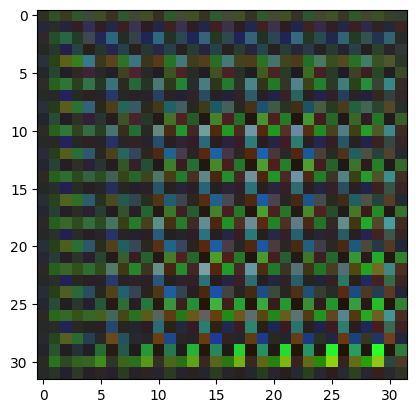

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 716ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 961ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 560ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 699ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 726ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 874ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 744ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 563ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 719ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step   
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 610ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 531ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 544ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 894ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 709ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 576ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 789

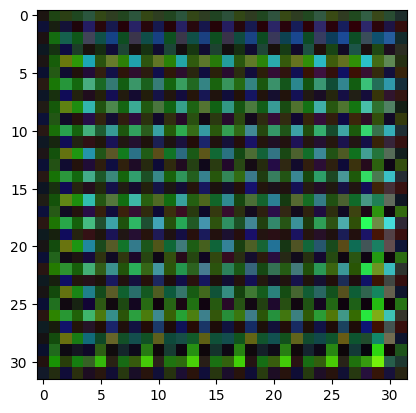

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 531ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 515ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 727ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step   
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 539ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 857ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 698ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 519ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 933ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 593ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 581ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 722ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 695ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 

KeyboardInterrupt: 

In [ ]:
for epochs in range(10):
    print(f'No of Epochs-> {epochs}')
    for i,batch in enumerate(dataset):
        train_discriminator(batch, batch.shape[0])
        train_generator(batch.shape[0])
        if i%100==0:
            print(f'Batch Images-> {i}')
            PATH = '/content/drive/MyDrive/Projects/Generate Faces Using GANs/generate_face'
            generate_and_save_image(path = f'{PATH}/epochs_{epochs}batch_{i}.jpg')